<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span><strong>Вывод</strong></a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Тестирование-моделей-на-тестовой-выборке" data-toc-modified-id="Тестирование-моделей-на-тестовой-выборке-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Тестирование моделей на тестовой выборке</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><strong>Вывод</strong></a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li><li><span><a href="#Важность-признаков" data-toc-modified-id="Важность-признаков-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Важность признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span><strong>Вывод</strong></a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работ:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from functools import partial

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  RandomizedSearchCV, TimeSeriesSplit, train_test_split,  GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

Загрузим файл и сразу установим первый столбец в качестве индекса.

In [2]:
# Загрузка данных
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df.index.is_monotonic

True

In [6]:
# Ресемплирование по часам
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Вывод**

1. Данные загружены. 
2. Колонка `datetime` определена как индекс таблицы, тип данных в преобразован в `datetime`.
3. Пропуски отсутствуют.
4. Данные монотонны.
5. Период наблюдения: `2018-03-01 00:00:00` - `2018-08-31 23:50:00` с интеравалом 10 минут.
6. Произвели ресемплирование данных на 1 час.

## Анализ

Для анализа данных создадим копию, чтоб после не чистить для модели.

In [8]:
df_copy = df.copy()

In [9]:
# Скользящее среднее
df_copy['mean'] = df_copy['num_orders'].rolling(24).mean()

Для начала давайте посмортим график нашего ряда:

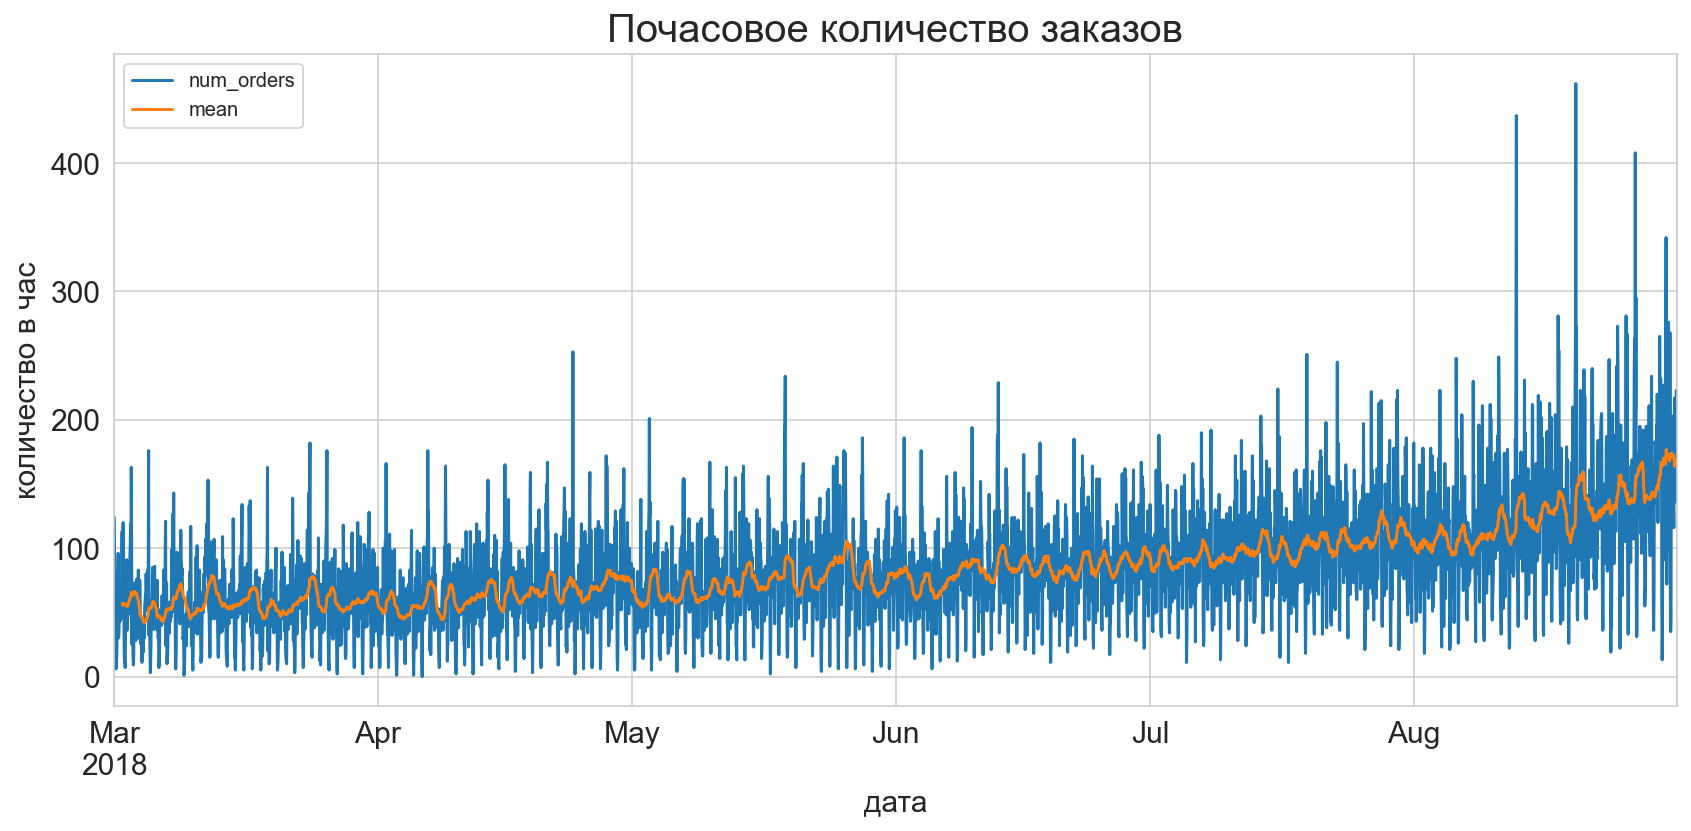

In [10]:
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
df_copy.plot(figsize=(14, 6))
plt.title('Почасовое количество заказов', fontsize = 20)
plt.xlabel('дата', fontsize = 15) 
plt.ylabel('количество в час', fontsize = 15)
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(rotation = 0, fontsize = 15)
plt.show();

Из графика видно, что наш ряд имеет небольшое кол-во выбросов, которые влияют на разброс. Кроме того анализировать заказы такси за каждый час не совсем верно, т.к., например, в конце или начале дня будут часы в которые количество заказов такси будет значительно больше, нежели в остальные. Поэтому есть смысл перейти к дневному интервалу и среднему значению заказов на нем, это избавит нас от выбросов и уменьшит колебания нашего ряда.

В `pandas` для этого есть удобная функция `resample()`, в качестве параметров ей передается период округления и аггрегатная функция.

In [11]:
df_day = df['num_orders'].resample('1d').sum()

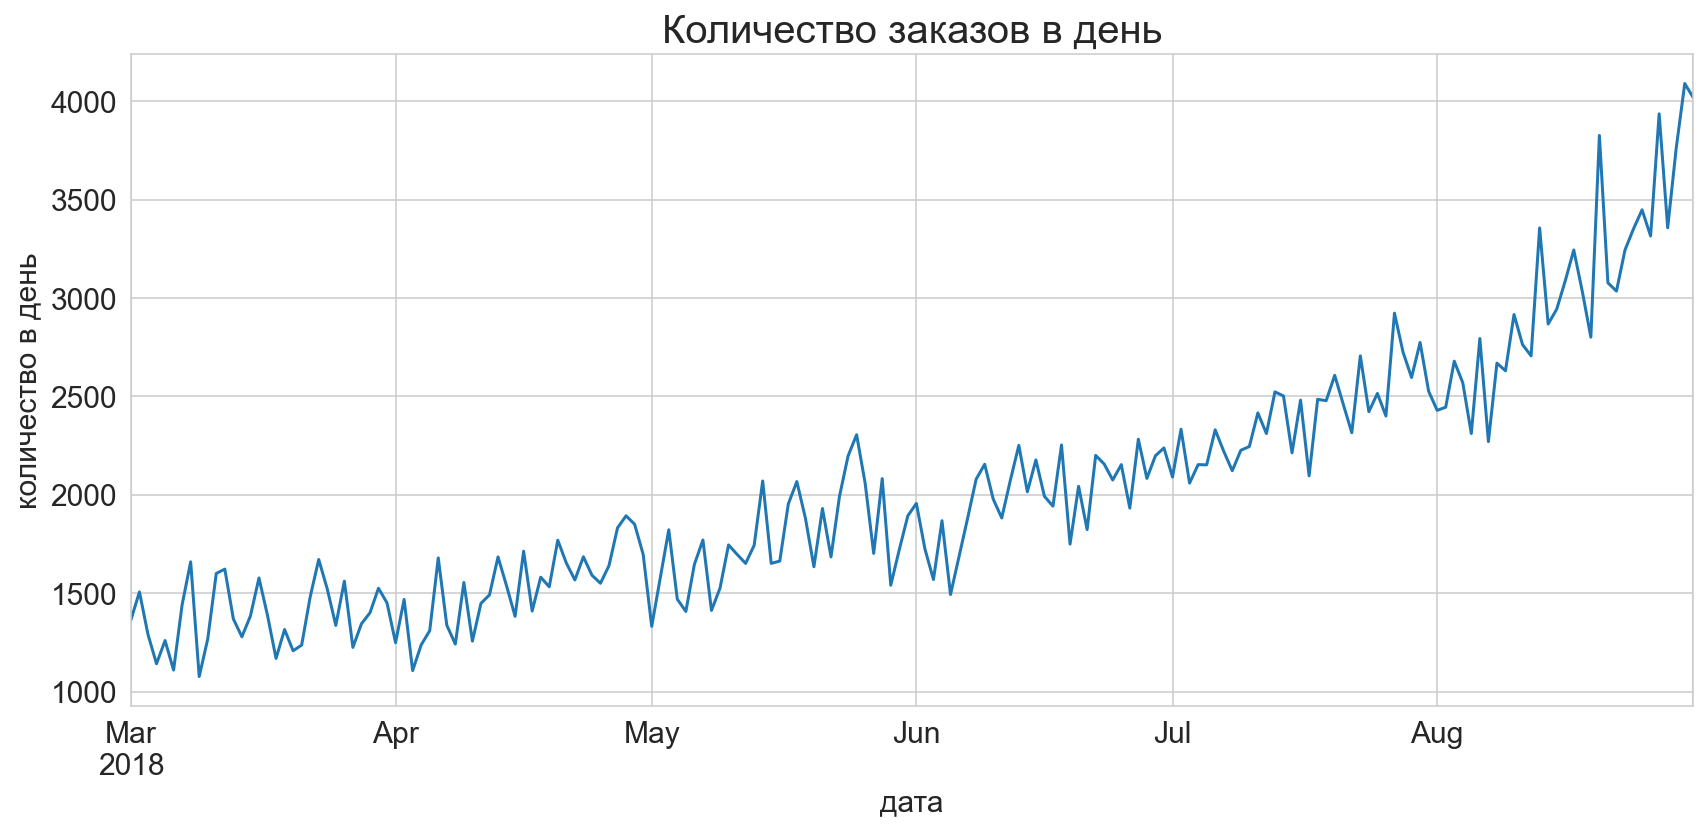

In [12]:
sns.set_style('whitegrid')
df_day.plot(figsize=(14, 6))
plt.title('Количество заказов в день', fontsize = 20)
plt.xlabel('дата', fontsize = 15) 
plt.ylabel('количество в день', fontsize = 15)
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(rotation = 0, fontsize = 15)
plt.show();

Как можно заметить, новый график не имеет ярких выбросов и имеет ярко выраженный тренд. Из это можно сделать вывод о том, что *ряд не является стационарным*.


Далее для более подробного анализа произведем декомпозицию данных о заказах такси на тренд, сезонность и остатки.

Для удобства создадим функцию декомпозиции и создания графиков тренда, сезонности и остатков.

In [13]:
# 
def decomposed_plot(data):
    """ Принимаем данные,
        Раскладывает временной ряд на три составляющие: тренд, сезонность и остаток
        Строим по каждой состовляющей график
    """
    decomposed = sm.tsa.seasonal_decompose(data)
    
    plt.figure(figsize=(16, 15))
    plt.subplot(311)
    # Чтобы график корректно отобразился, указываем его
    # оси ax, равными plt.gca() (англ. get current axis,
    # получить текущие оси)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Тренд декомпозиции количества заказов такси', fontsize = 20)
    plt.xlabel('дата', fontsize = 15) 
    plt.ylabel('количество в день', fontsize = 15)
    plt.xticks(rotation = 0, fontsize = 15)
    plt.yticks(rotation = 0, fontsize = 15)
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca()) 
    plt.title('Сезонность декомпозиции количества заказов такси', fontsize = 20)
    plt.xlabel('дата', fontsize = 15) 
    plt.ylabel('количество в день', fontsize = 15)
    plt.xticks(rotation = 0, fontsize = 15)
    plt.yticks(rotation = 0, fontsize = 15)
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Остаток декомпозиции количества заказов такси', fontsize = 20)
    plt.xlabel('дата', fontsize = 15) 
    plt.ylabel('количество в день', fontsize = 15)
    plt.xticks(rotation = 0, fontsize = 15)
    plt.yticks(rotation = 0, fontsize = 15)
    plt.tight_layout();
    return decomposed

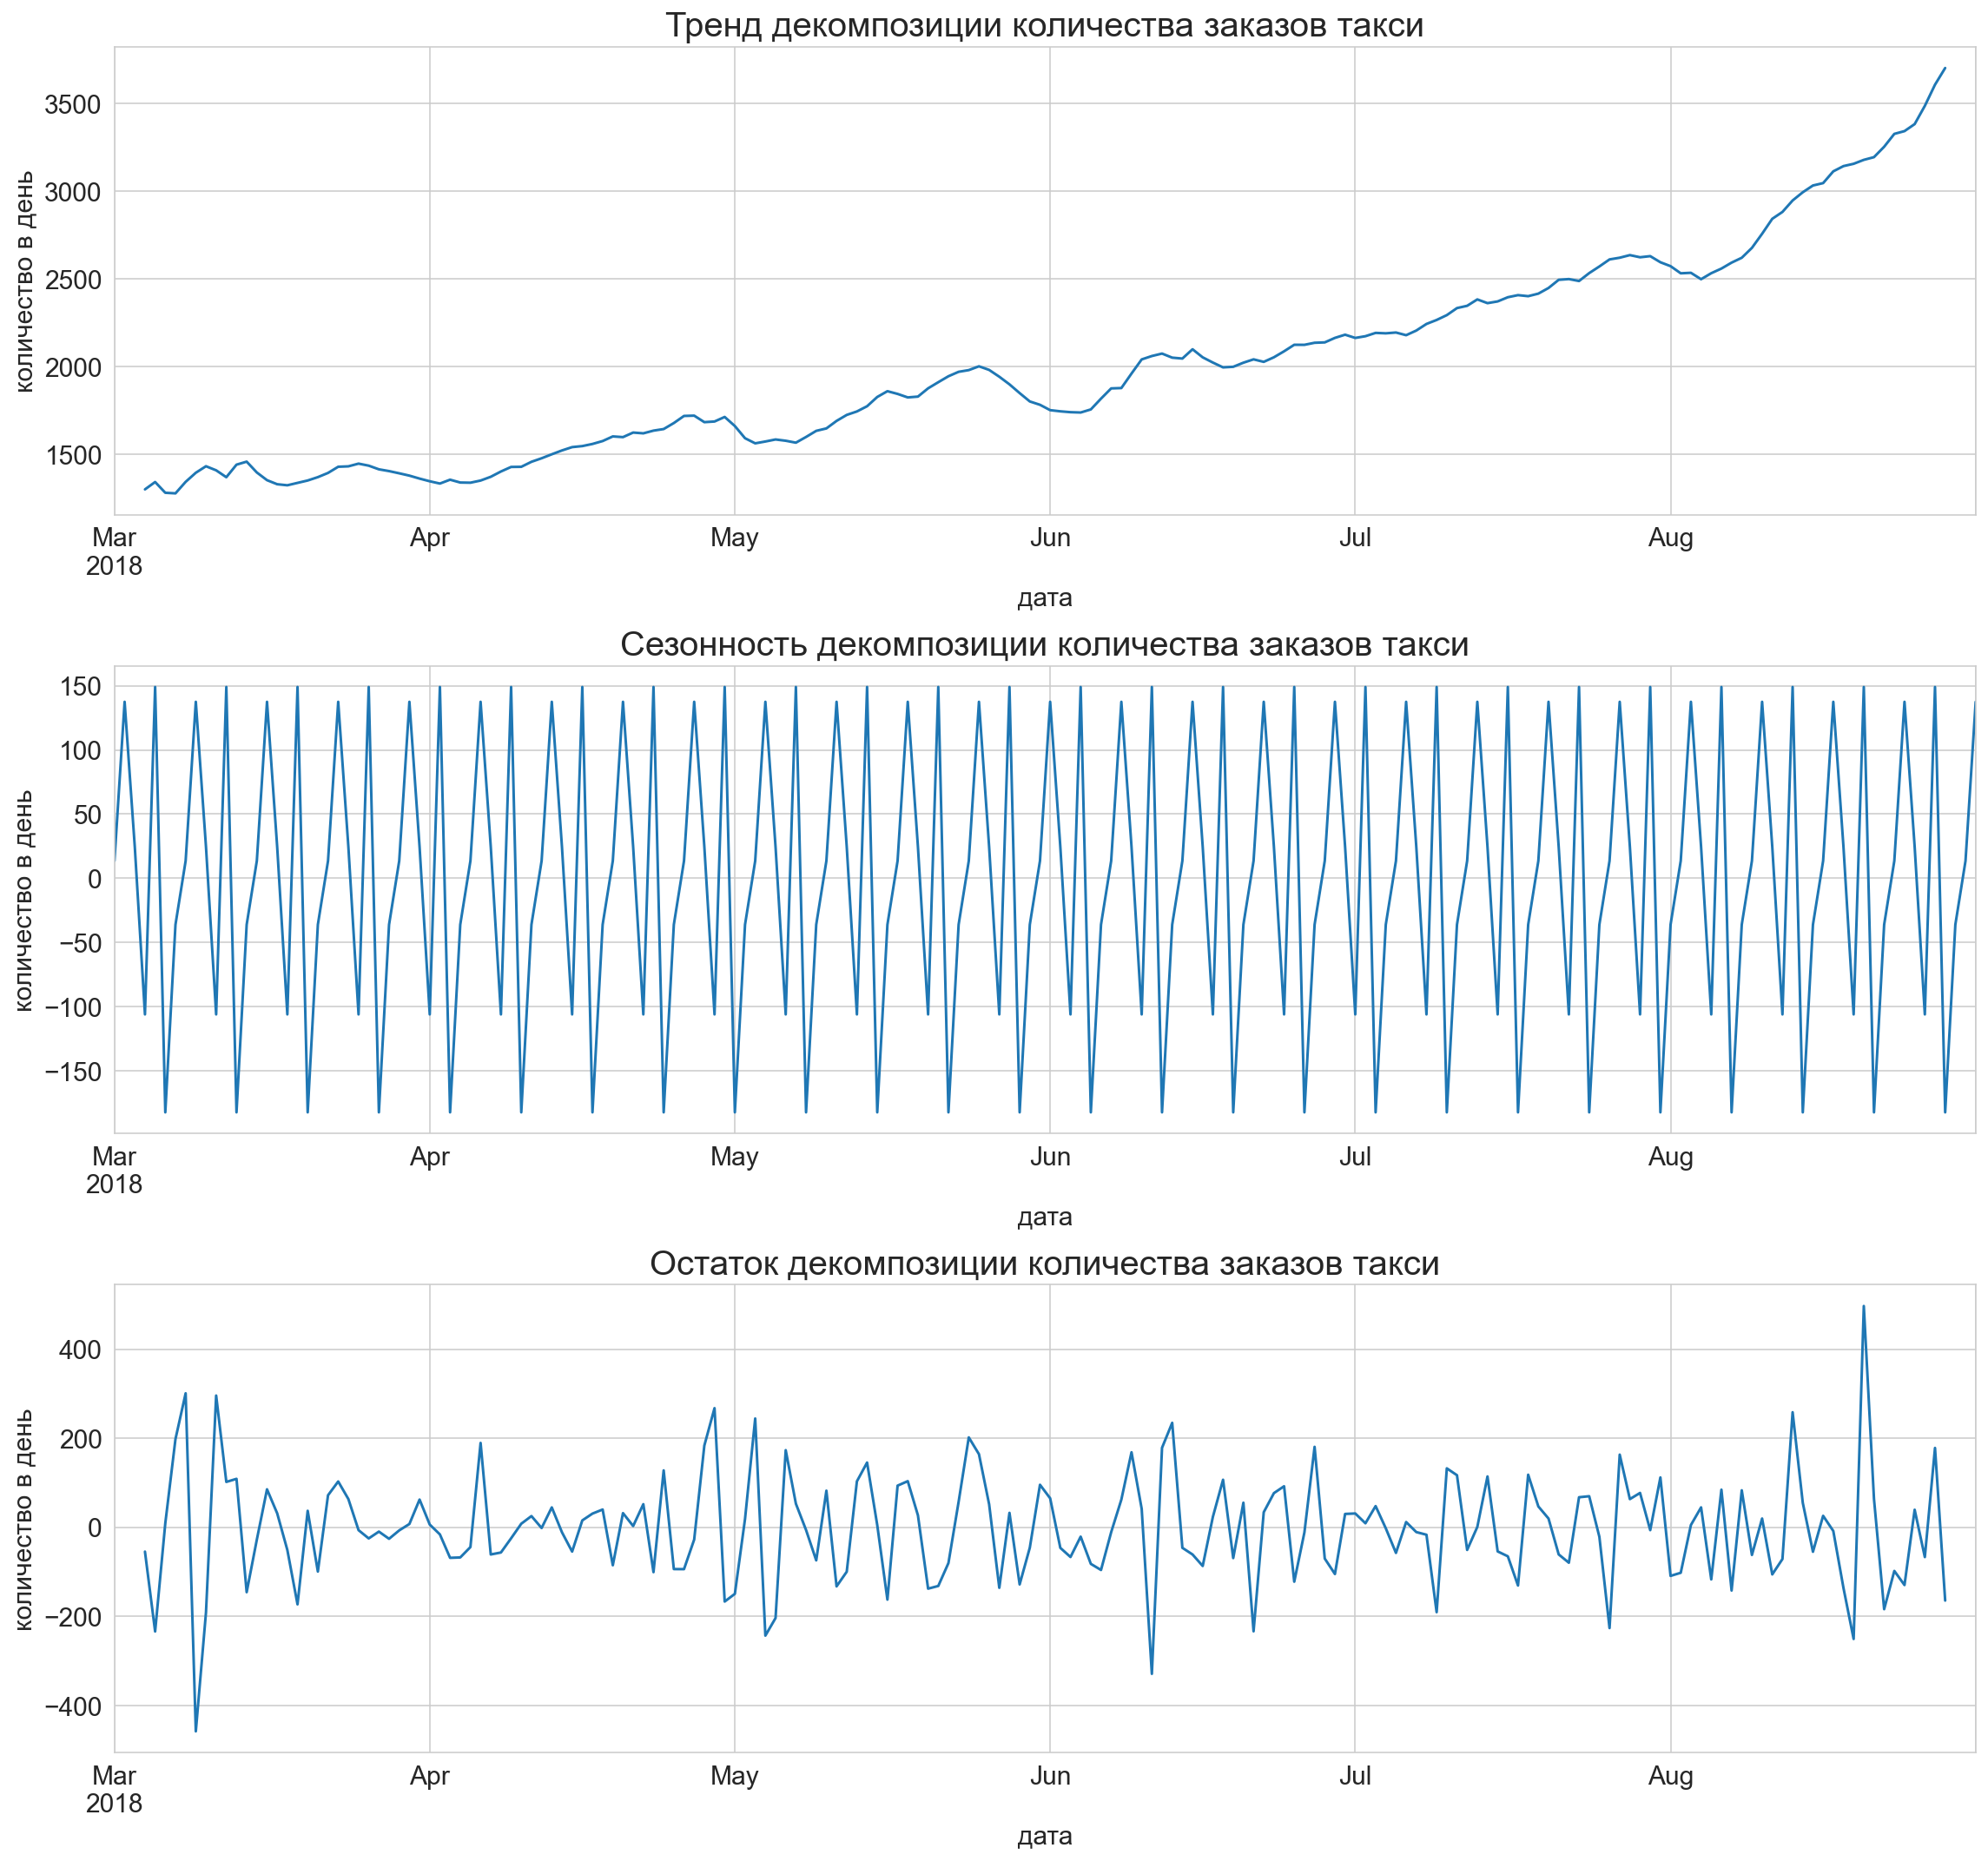

In [14]:
decomposed_day = decomposed_plot(df['num_orders'].resample('1d').sum()); 


In [15]:
print('Стандартное отклонение остатка количества заказов такси в день:', decomposed_day.resid.std())

Стандартное отклонение остатка количества заказов такси в день: 123.28196551996496


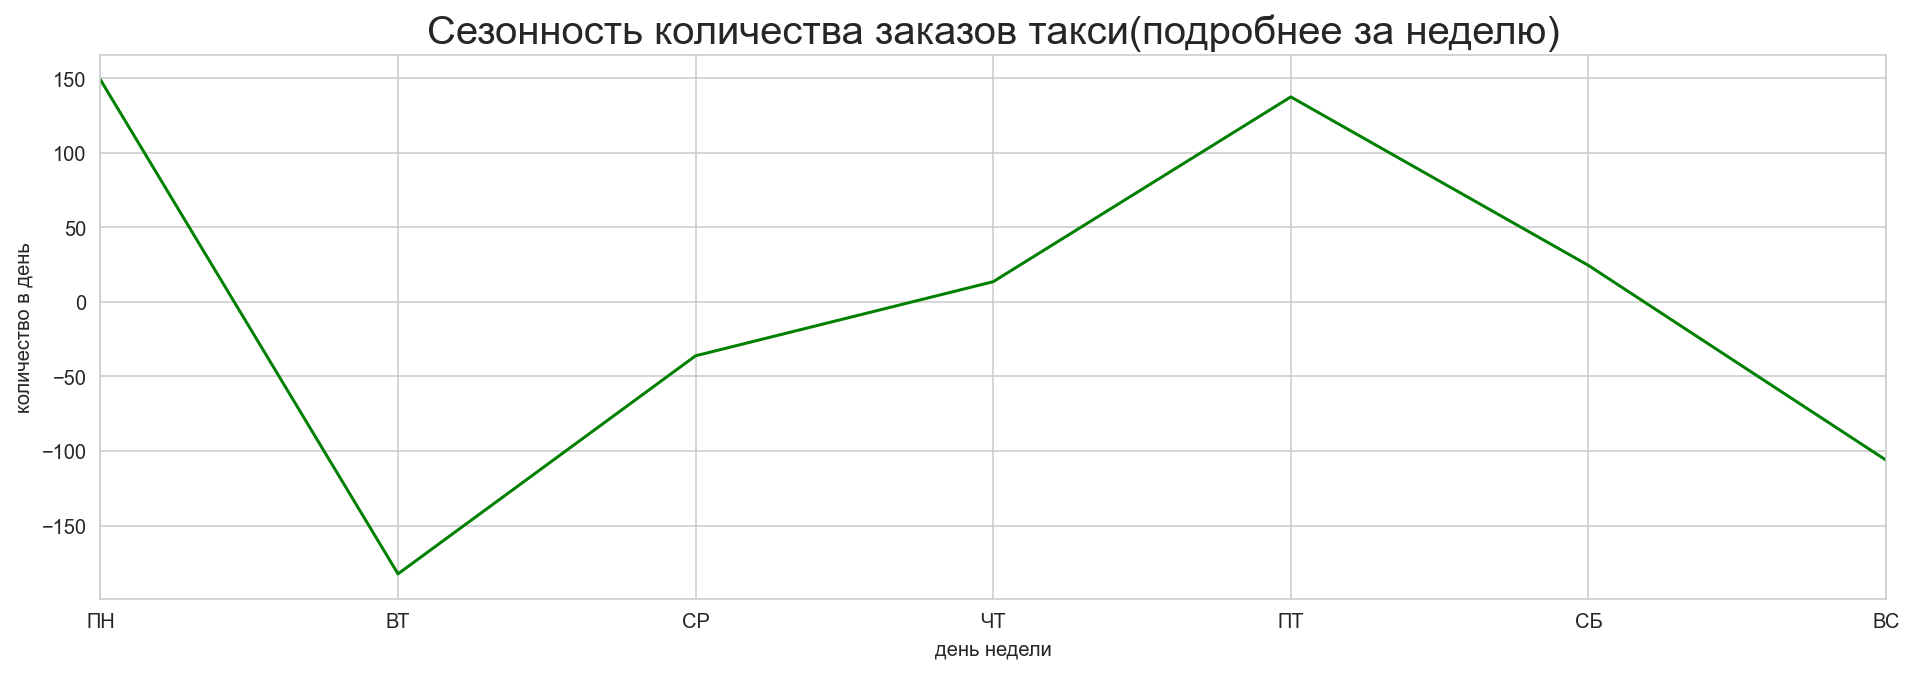

In [16]:
# сезонная составляющая за неделю
ax = decomposed_day.seasonal['2018-03-05 00:00:00':'2018-03-11 00:00:00'].plot(figsize=(16, 5), color='g')
ax.set_title('Сезонность количества заказов такси(подробнее за неделю)', fontsize=20)
ax.set(ylabel='количество в день', xlabel='день недели');
plt.xticks(decomposed_day.seasonal['2018-03-05 00:00:00':'2018-03-11 00:00:00'].index, ['ПН','ВТ','СР','ЧТ','ПТ','СБ','ВС']);

При разложении временного ряда на составляющие видно:
1. Восходящий тренд, заказы такси с марта по август растут.
2. Недельная сезонность - внутри недели колебания количества заказов в пределах +- 150 в зависимости от дня недели.
3. Остаток декомпозиции составляет +-400 заказов со стандартным отклонением 123 заказа.

Для лучшего понимания как меняется количество заказов в течении недели и дня, рассмотрим более подробно промежуток времени размером в одну неделю.

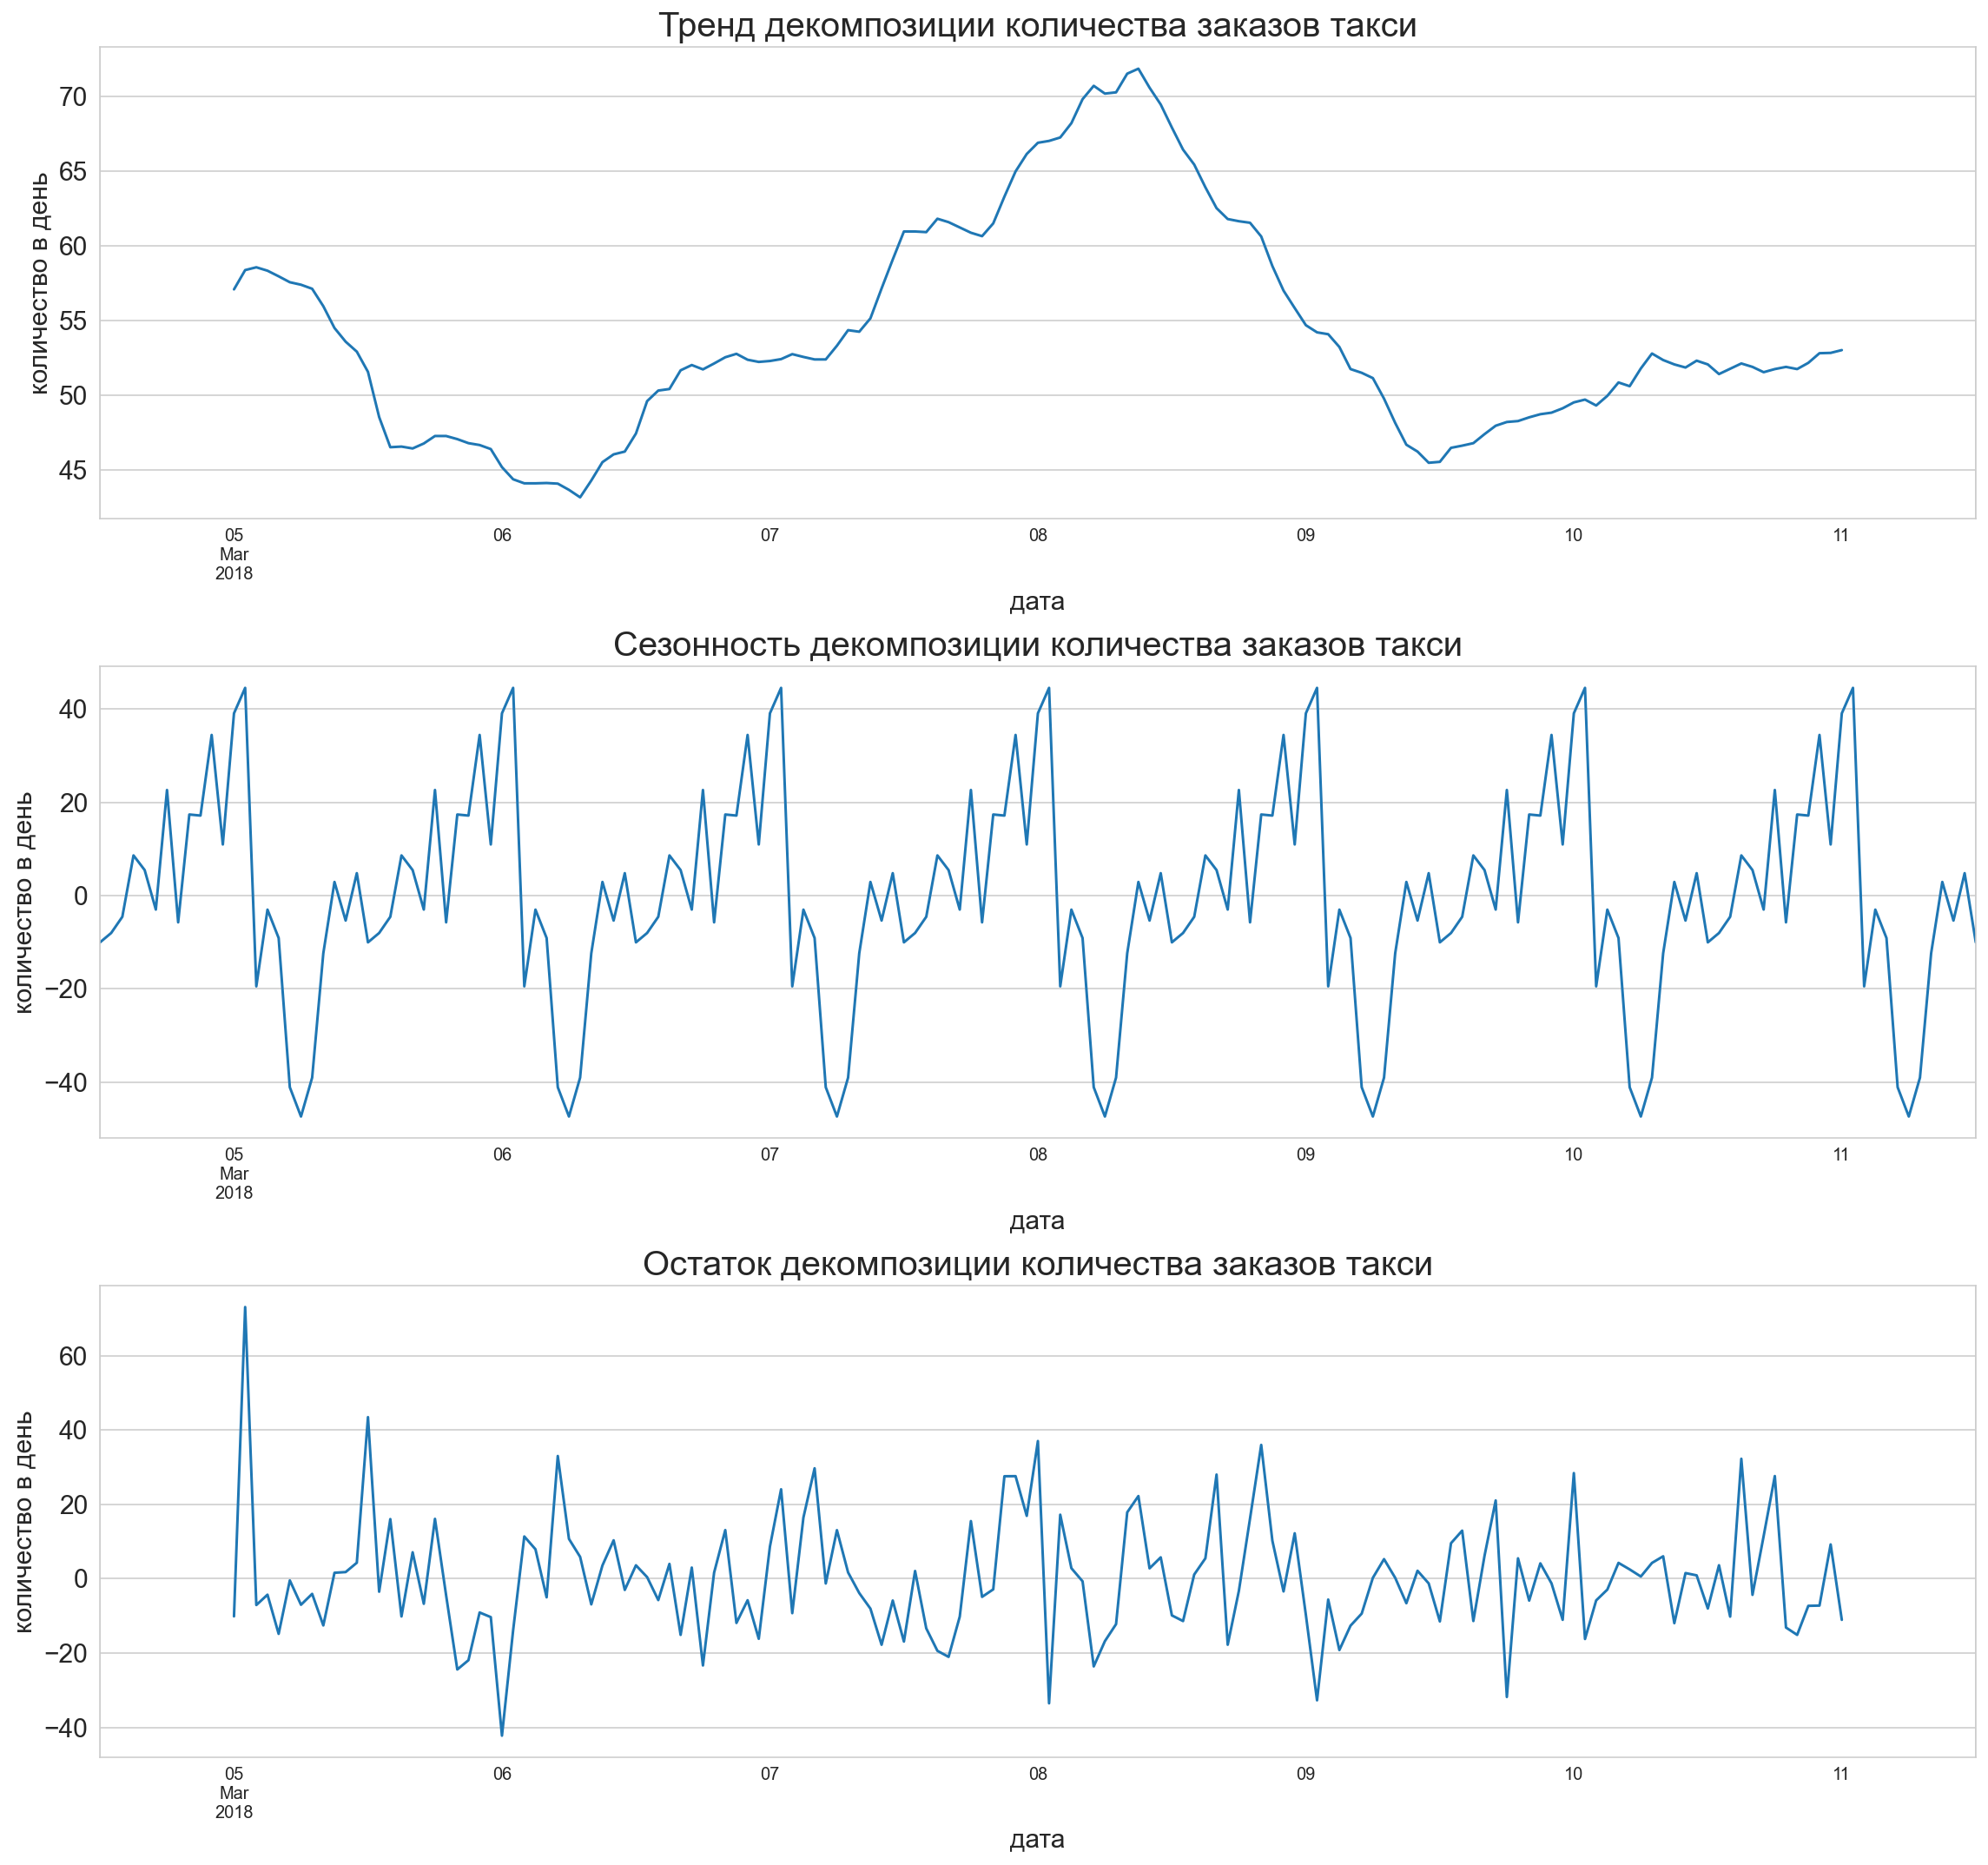

In [17]:
# Почасовая декомпозиция за недельный период 
decomposed_plot(df.loc['2018-03-04 12:00:00':'2018-03-11 12:00:00']); 


- Количество заказов зависит от дня недели. Больше всего люди используют такси в понедельник и пятницу, меньше всего во вторник и воскресенье.
- Также, таблюдается дневная сезонность. Заказы такси в одни и теже часы имеют схожий характер. Минимум заказов ночью. С 06 утра заказы начинают расти вплоть до 24 часов.


**Проверка на стационарность.**

Многие методы и модели основаны на предположениях о стационарности ряда, но как было замечено ранее наш ряд таковым скорее всего не является. Поэтому для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле `statsmodels` есть функция `adfuller()`:

In [18]:
test = sm.tsa.adfuller(df)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -3.0689242890279407
p-value:  0.02894005140261409
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


Проведенный тест подтвердил предположения о не стационарности ряда. Во многих случаях взятие разности рядов позволяет это сделать.Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.

Итак, давайте определим порядок интегрированного ряда для нашего ряда:

In [19]:
df_diff_1 = df.diff(periods=1).dropna()

В коде выше функция `diff()` вычисляет разность исходного ряда с рядом с заданным смещением периода. Период смещения передается как параметр `period`. Т.к. в разности первое значение получиться неопределенным, то нам надо избавиться от него для этого и используется метод `dropna()`.

Проверим получившийся ряд на стационарность:

In [20]:
test = sm.tsa.adfuller(df_diff_1)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -15.79323425740974
p-value:  1.0958776746531843e-28
Critical values:  {'1%': -3.431842843698785, '5%': -2.8621996550511697, '10%': -2.56712113869159}
Единичных корней нет, ряд стационарен


Как видно из кода выше получившийся ряд первых разностей приблизился к стационарному. Для полной уверенности разобъем его на несколько промежутков и убедимся мат. ожидания на разных интервалах:

In [21]:
m = df_diff_1.index[int(len(df_diff_1.index)/2)+1]
r1 = sm.stats.DescrStatsW(df_diff_1[m:])
r2 = sm.stats.DescrStatsW(df_diff_1[:m])
print('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  [0.95879106]


Высокое `p-value` дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда. Осталось убедиться в отсутствии тренда для этого построим график нашего нового ряда:

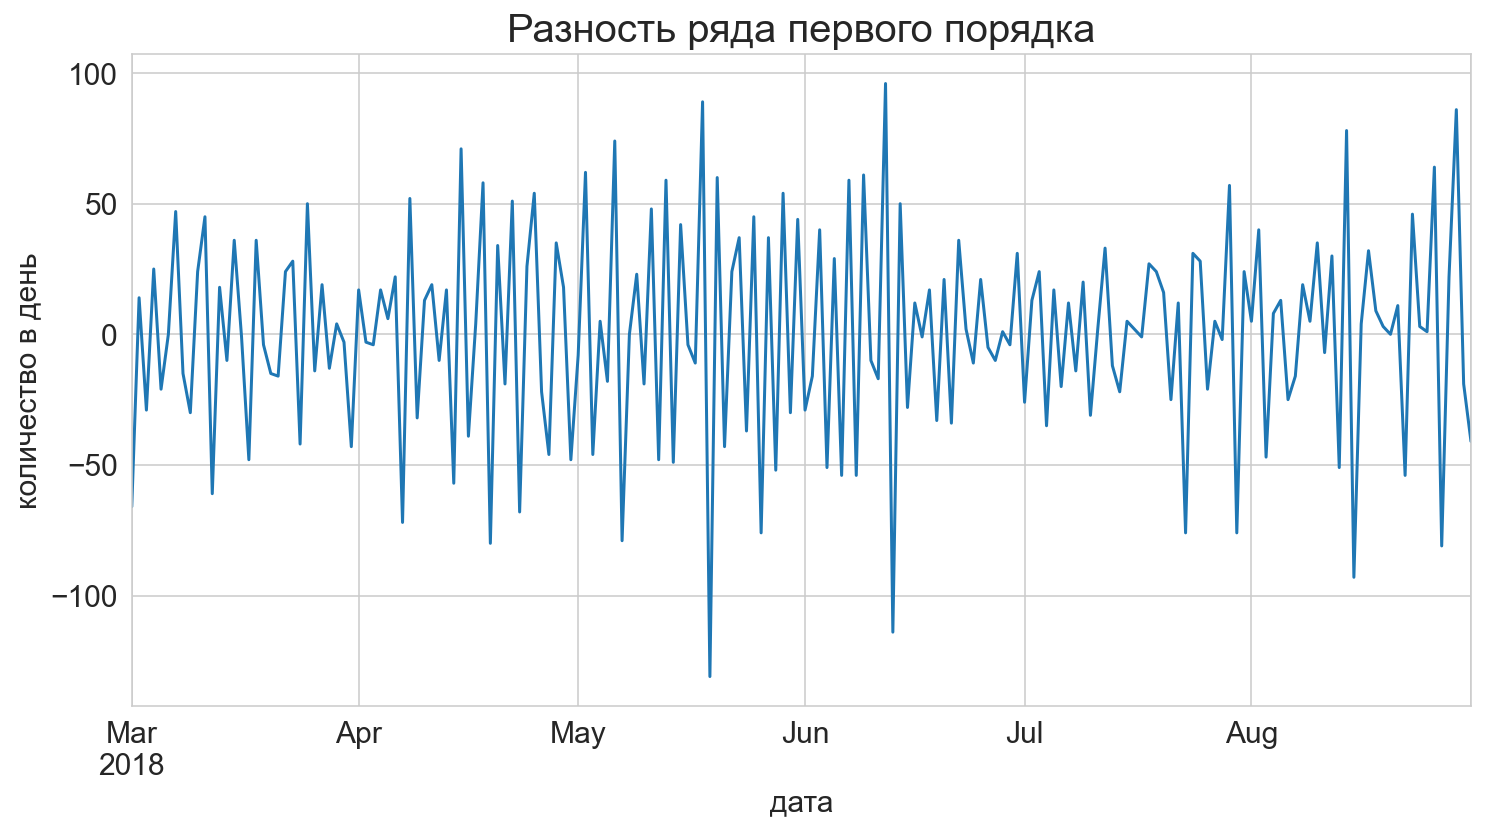

In [22]:
df_diff_1['num_orders'].resample('1d').sum().plot(figsize=(12,6))
plt.title('Разность ряда первого порядка', fontsize = 20)
plt.xlabel('дата', fontsize = 15) 
plt.ylabel('количество в день', fontsize = 15)
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(rotation = 0, fontsize = 15)
plt.show();


Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — *интегрированным рядом первого порядка*.

###### **Вывод по разделу**

1. Наблюдается восходящий тренд количества заказов такси от марта к августу 2018 года.
2. Недельная сезонность. Количество заказов зависит от дня недели. Больше всего люди используют такси в понедельник и пятницу, меньше всего во вторник и воскресенье.
3. Также, таблюдается дневная сезонность. Заказы такси в одни и теже часы имеют схожий характер. Минимум заказов ночью. С 06 утра заказы начинают расти вплоть до 24 часов. 
4. Наш исходный ряд не является стационарным
4. Но в тоже время наш исходный ряд — *интегрированный ряд первого порядка*.


## Обучение

Обучим несколько моделей:
   - Линейную регрессию;
   - Случайный лес;
   - CatBoostRegressor.
    
Предварительно определим константы и функции

In [23]:
RSTATE = 12345
# RMSE
rmse = partial(mean_squared_error, squared=False)

Функция для создания признаков:
1. Месяц, день и день недели;
2. Сдвиг данных;
3. Скользящее среднее.

Максимальное значение сдвига и размер окна для скользящего среднего определим опытным путём.

In [24]:
# Подготовка признаков

def make_features(data, max_lag, rolling_mean_size):
    """ Принимаем данные, максимальный сдвиг и окно для скользящего среднего
        Создаём признаки и записываем результаты напрямую в датафрейм
    """
    data = pd.DataFrame(data)
    # Создание признаков месяц, день, день недели
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    # Создание сдвигов
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # Создание скользящего среднего
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

# Вызов функции создания признаков
df_learn = make_features(df['num_orders'], 24, 30)

### Линейная регрессия

При анализе данных замеченны два характерных периода: суточный (24 часа) и недельный (7*24= 168 часов).

Чтобы определить размер скользящего окна и количество лаговых переменных, создадим цикл, который обучит для нас несколько быстрых моделей - например, моделей линейной регрессии.  В результате работы цыкла получим наилучший набот признаков `features_train`, `features_valid`, `features_test` для дальнейшего моделирования.

In [25]:
lags = [6, 12, 24, 48, 96, 144, 168, 192, 240, 384]
rolling_size = [12, 24, 30, 36, 48, 168]

In [26]:
%%time

#df_copy = df.copy()

best_lin_reg_result = 20000
best_lag = 0
best_rolsize = 0

rolsize = []
lag_t = []
rmse_t = []
time_t = []


for rs in rolling_size:
    df_copy = df.copy()
    for lag in lags:
    
        make_features(df_copy, lag, rs)
    
        train, valid_test = train_test_split(df_copy, test_size=0.2, shuffle=False)

        valid, test = train_test_split(valid_test, test_size=0.5, shuffle=False)
    
        train = train.dropna()
    
        features_train_ = train.drop('num_orders', axis=1)
        target_train_ = train['num_orders']

        features_valid_ = valid.drop('num_orders', axis=1)
        target_valid_ = valid['num_orders']
    
        features_test_ = test.drop('num_orders', axis=1)
        target_test_ = test['num_orders']
    
        lin_reg = LinearRegression()
        lin_reg.fit(features_train_, target_train_)
        
        time_s = -time.time()
        pred_valid = lin_reg.predict(features_valid_)
        time_s += time.time()
    
        result = rmse(target_valid_, pred_valid)
        
        rolsize.append(rs)
        lag_t.append(lag)
        rmse_t.append(result)
        time_t.append(time_s)
    
        if result < best_lin_reg_result:
            best_lin_reg = lin_reg
            best_lin_reg_result = result
            best_lag = lag
            best_rolsize = rs
            best_lin_pred = pred_valid
            best_time = time_s
            features_train = features_train_
            target_train = target_train_

            features_valid = features_valid_
            target_valid = target_valid_
    
            features_test = features_test_
            target_test = target_test_
# 
print('Параметры лучшей модели: \n', 
      f'RMSE: {best_lin_reg_result} \n',
      f'rolling_size = {best_rolsize} \n',
      f'lag_max      = {best_lag} \n',
      f'best_time    = {best_time} \n'
)

Параметры лучшей модели: 
 RMSE: 28.03305835423004 
 rolling_size = 168 
 lag_max      = 168 
 best_time    = 0.006168842315673828 

CPU times: user 35.8 s, sys: 1.22 s, total: 37 s
Wall time: 10.2 s


Лучший результат RMSE= 28 получился с параметрами размер скользящего окна и количество лаговых переменных равными 168, то есть равными недельной сезонности.

Из интереса посмотрим на остальные результаты

In [27]:
rez_data = pd.DataFrame(data={'rolling_size' : rolsize,
                              'max_lag' : lag_t,
                              'rmse' : rmse_t,
                              'time' : time_t},
                       )


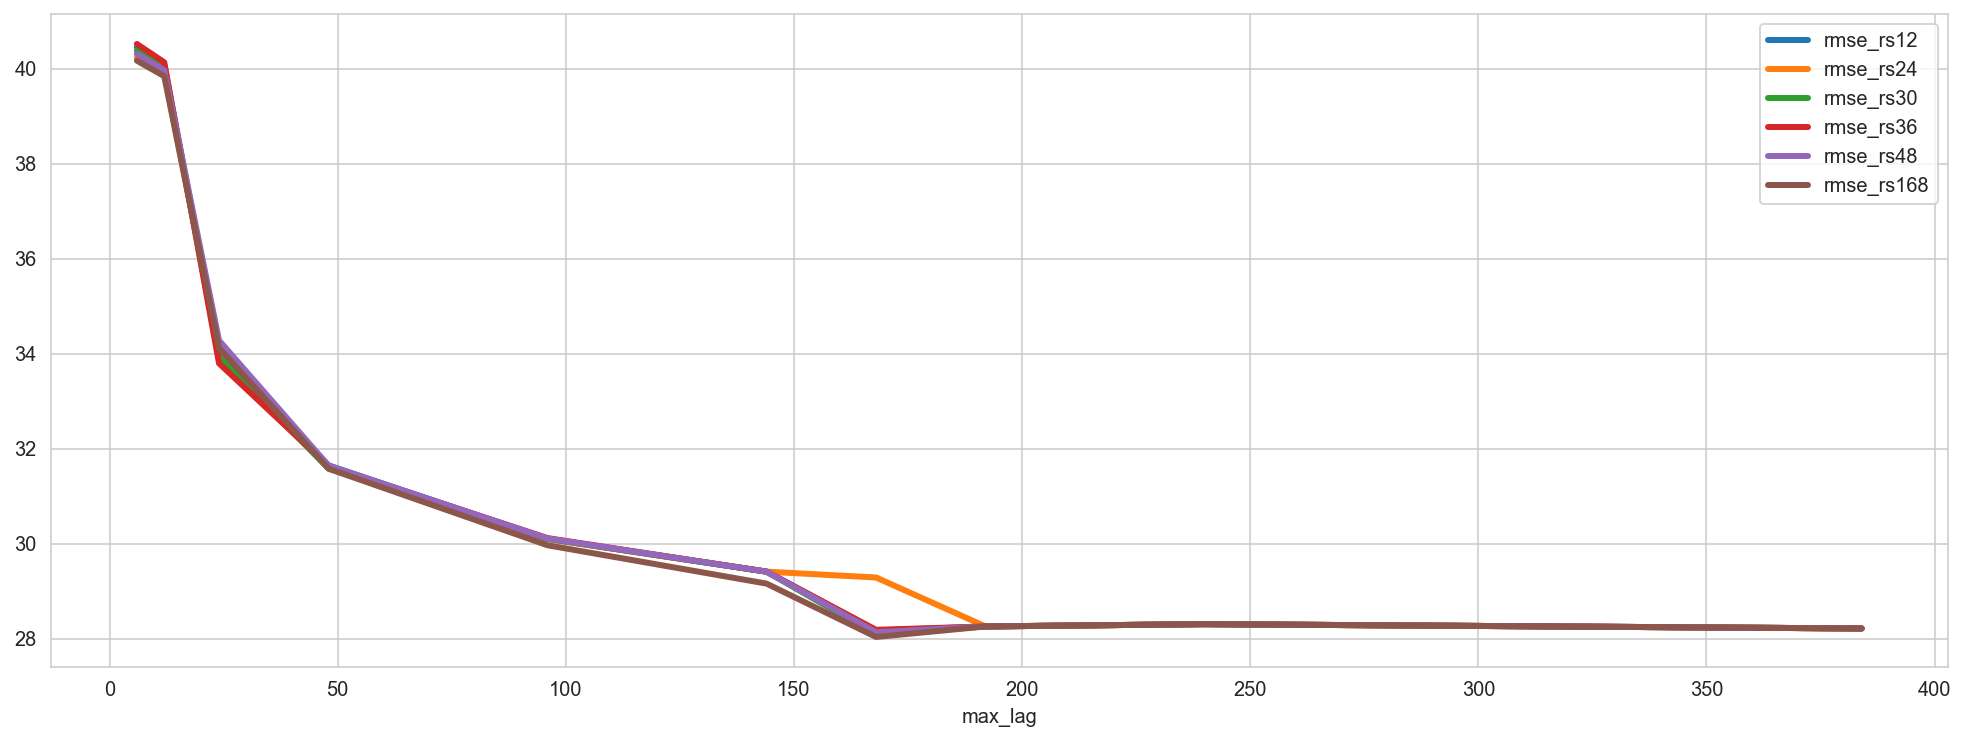

In [28]:
pl_data = rez_data.loc[rez_data['rolling_size']==12, ['max_lag']]
rmse_col = []
time_col = []
for rs in rolling_size:
    col1 = 'rmse_rs' + str(rs)
    col2 = 'time_rs' + str(rs)
    rmse_col.append(col1)
    time_col.append(col2)
    
    pl_data[[col1, col2]] = rez_data.loc[rez_data['rolling_size']==rs, ['rmse','time']].reset_index(drop=True)
pl_data = pl_data.set_index('max_lag')
pl_data[rmse_col].plot(linewidth=3, figsize=(17, 6));


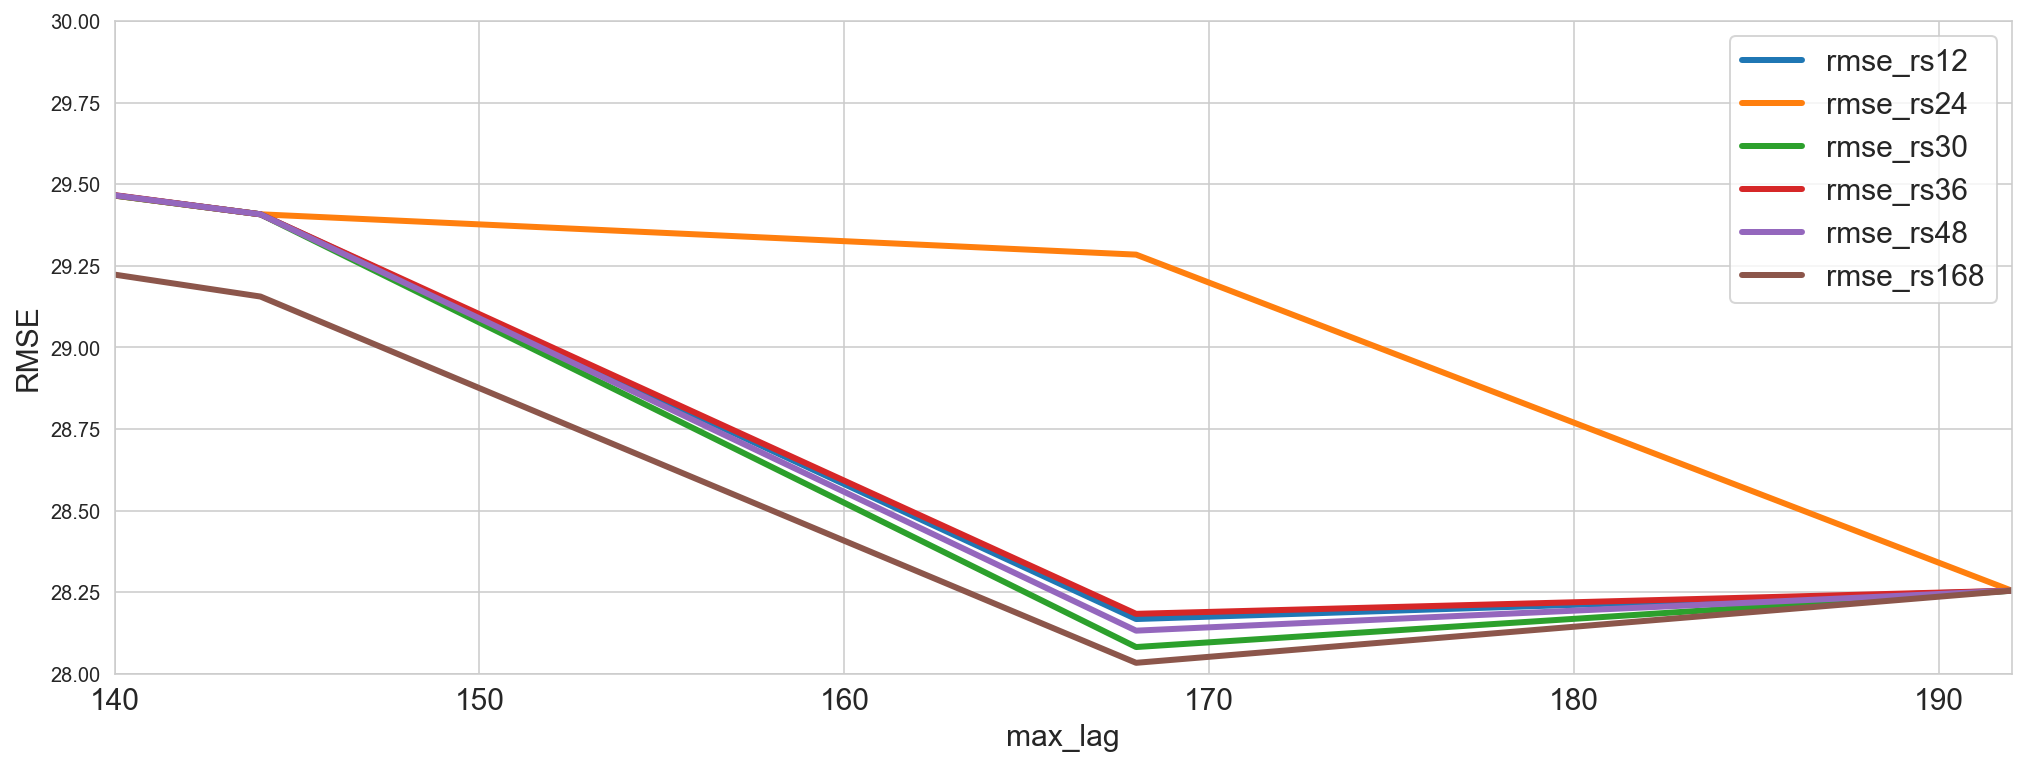

In [29]:
pl_data[rmse_col].plot(linewidth=3, figsize=(17, 6))
plt.xlabel('max_lag', fontsize = 15) 
plt.ylabel('RMSE', fontsize = 15) 
plt.xlim(140, 192)
plt.ylim(28, 30)
#plt.xticks(lags)
plt.xticks(fontsize = 15)
plt.grid(True) 
plt.legend(loc='upper right',
           fontsize = 15,
          )
plt.show();

При max_lag = 168 наблюдается локальный минимум по RMSE при всех размеров скользящего окна, кроме равного 24.   

Итак, 
- мы создали и выделили признаки (где 168 лаговых переменных и размер скользящего окна равный 168), которые будем использовать для обучения других моделей
- обучили первую модель: модель линейной регрессии 


### Случайный лес

В начале подберем гиперпараметры.

Будем использовать `GridSearch` при подборе параметров, но поскольку мы не можем просто так осуществлять кросс-валидацию на временных рядах, воспользуемся инструментом `TimeSeriesSplit`, который позволит нам корректно осуществить кросс-валидацию.

In [30]:
rf_model = RandomForestRegressor(random_state=RSTATE)
cv = TimeSeriesSplit(n_splits=2)

При использовании `GridSearch` валидационная выборка не нужна, поэтому объединим выборки train  и valid

In [31]:
features_train=features_train.append(features_valid)
target_train=target_train.append(target_valid)

In [32]:
%%time
forest_params = {'n_estimators':[20, 50],
                'max_depth': range(21,23),
                'max_features': range(2, len(features_train.columns) + 1,20),
}

best_forest = GridSearchCV(rf_model, forest_params, scoring='neg_mean_squared_error', 
                           cv=cv, n_jobs=-1, verbose=True)

CPU times: user 104 µs, sys: 6 µs, total: 110 µs
Wall time: 119 µs


In [33]:
%%time
best_forest.fit(features_train, target_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
CPU times: user 14.1 s, sys: 103 ms, total: 14.3 s
Wall time: 1min 54s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': range(21, 23),
                         'max_features': range(2, 173, 20),
                         'n_estimators': [20, 50]},
             scoring='neg_mean_squared_error', verbose=True)

In [34]:
(-best_forest.best_score_)**0.5

24.230409929855597

In [35]:
print('Лучшие параметры модели случайный лес')
best_forest.best_params_

Лучшие параметры модели случайный лес


{'max_depth': 21, 'max_features': 102, 'n_estimators': 50}

### CatBoost

In [36]:
cat_model = CatBoostRegressor(silent=True, random_state=RSTATE)

In [37]:
cat_parametrs = { 'l2_leaf_reg': range(1,10),
                 'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8, 1],
                 'depth' : range(1,10)
                }

In [38]:
%%time
# Вызываем функцию подбора гиперпараметров
best_cat =  RandomizedSearchCV(cat_model, 
                               cat_parametrs,
                               scoring='neg_root_mean_squared_error', 
                               cv=cv,
                               n_jobs=-1,
                               random_state = RSTATE
                              )


CPU times: user 0 ns, sys: 68 µs, total: 68 µs
Wall time: 78.7 µs


In [39]:
%%time
best_cat.fit(features_train, target_train)

CPU times: user 51 s, sys: 2.71 s, total: 53.7 s
Wall time: 15min 18s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f311d178d90>,
                   n_jobs=-1,
                   param_distributions={'depth': range(1, 10),
                                        'l2_leaf_reg': range(1, 10),
                                        'learning_rate': [0.01, 0.02, 0.05,
                                                          0.08, 0.1, 0.2, 0.5,
                                                          0.8, 1]},
                   random_state=12345, scoring='neg_root_mean_squared_error')

In [40]:
-best_cat.best_score_

23.361271777942875

In [41]:
print('Лучшие параметры модели CatBoost')
best_forest.best_params_

Лучшие параметры модели CatBoost


{'max_depth': 21, 'max_features': 102, 'n_estimators': 50}

### **Вывод**

- Создали признаки, экспериментально подобрав размер скользящего окна и количество лаговых переменных (переменных сдвига)

- Провели обучение и подбор гиперпараметров для нескольких моделей. Наименьшее значение ошибки RMSE показала модель CatBootRegressor RMSE=23.4. Модель Случайный лес также демонстрирует достаточно хорошее качество: RMSE=24.2. Не далеко от них отстала и линейная регрессия с RMSE=28. 

## Тестирование


1. Протестируем на тестовой выборке наши модели с наилучшими параметрами:
    - LinearRegression
    - RandomForestRegressor
    - CatBootRegressor
2. Сравним результат работы модели на тестовой выборке с результатами константной модели и модели прогнозирующей предъидущим значением.
3. Посмотрим на важность признаков.

### Тестирование моделей на тестовой выборке

In [42]:
# Линейная регрессия
pred_test_lr = best_lin_reg.predict(features_test)
lr_rmse = rmse(target_test, pred_test_lr)
print(f'RMSE линейной регрессии на тестовой выборке: {lr_rmse:.2f}')


RMSE линейной регрессии на тестовой выборке: 36.54


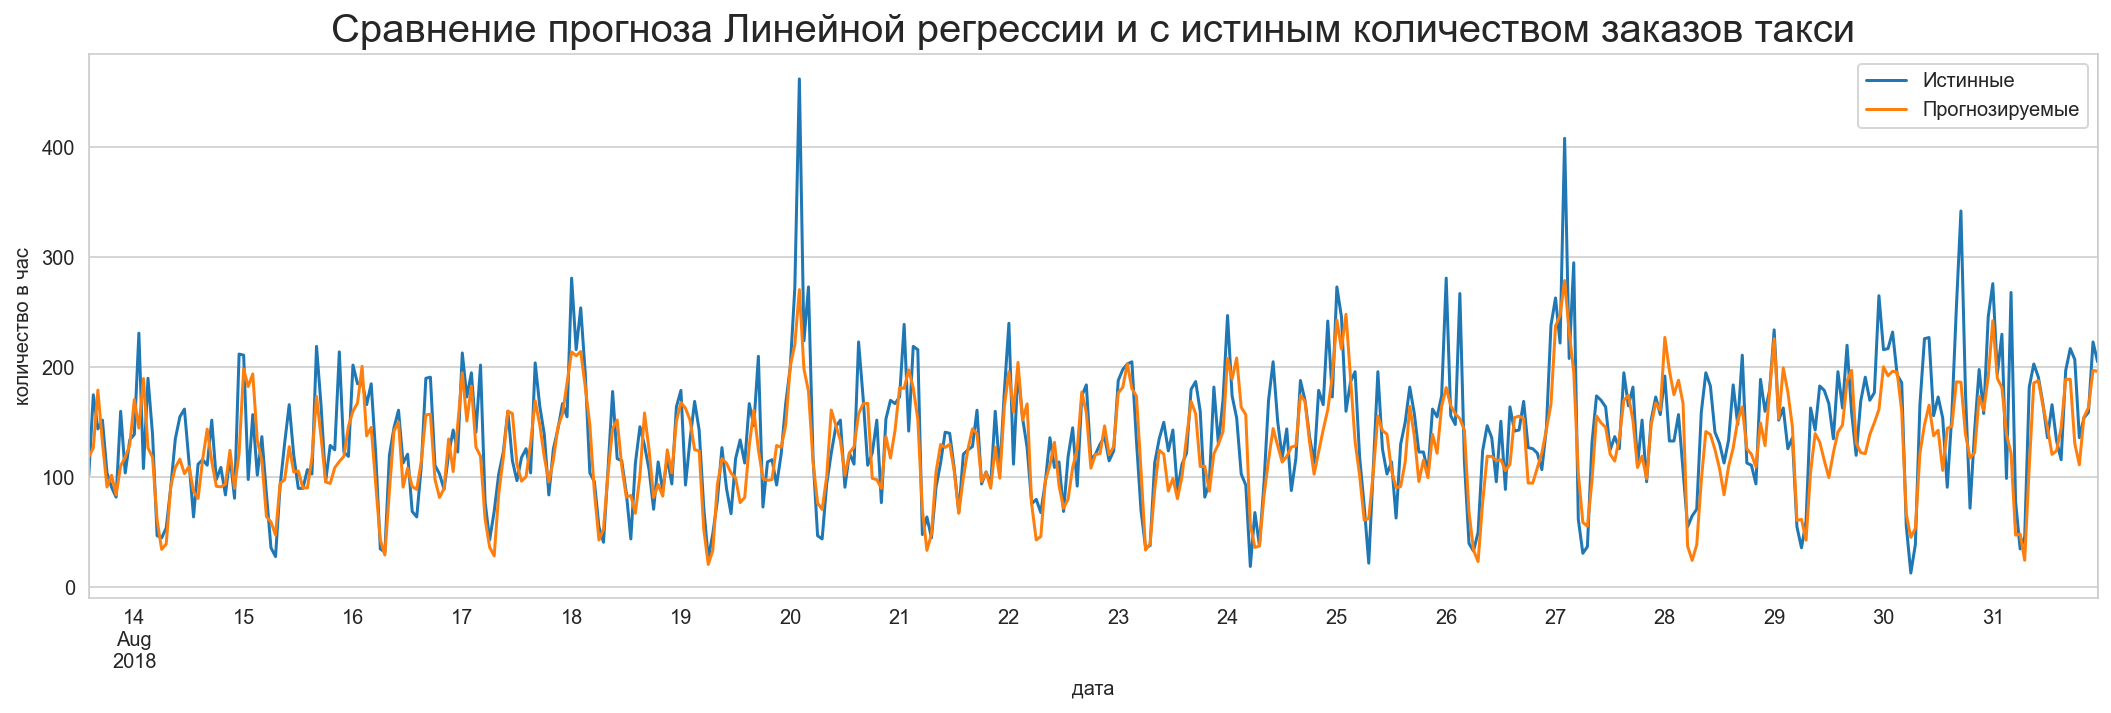

In [43]:
# Отображение предсказания и истинных значений
ax = pd.DataFrame(data = {'Истинные':target_test, 'Прогнозируемые':pred_test_lr}).plot(figsize=(18, 5))
ax.set_title('Сравнение прогноза Линейной регрессии и с истиным количеством заказов такси', fontsize=20)
ax.set(ylabel='количество в час', xlabel='дата');


In [44]:
# Случайный лес
pred_test_rf = best_forest.predict(features_test)
rf_rmse = rmse(target_test, pred_test_rf)
print(f'RMSE модели Случайный лес на тестовой выборке: {rf_rmse:.2f}')


RMSE модели Случайный лес на тестовой выборке: 38.42


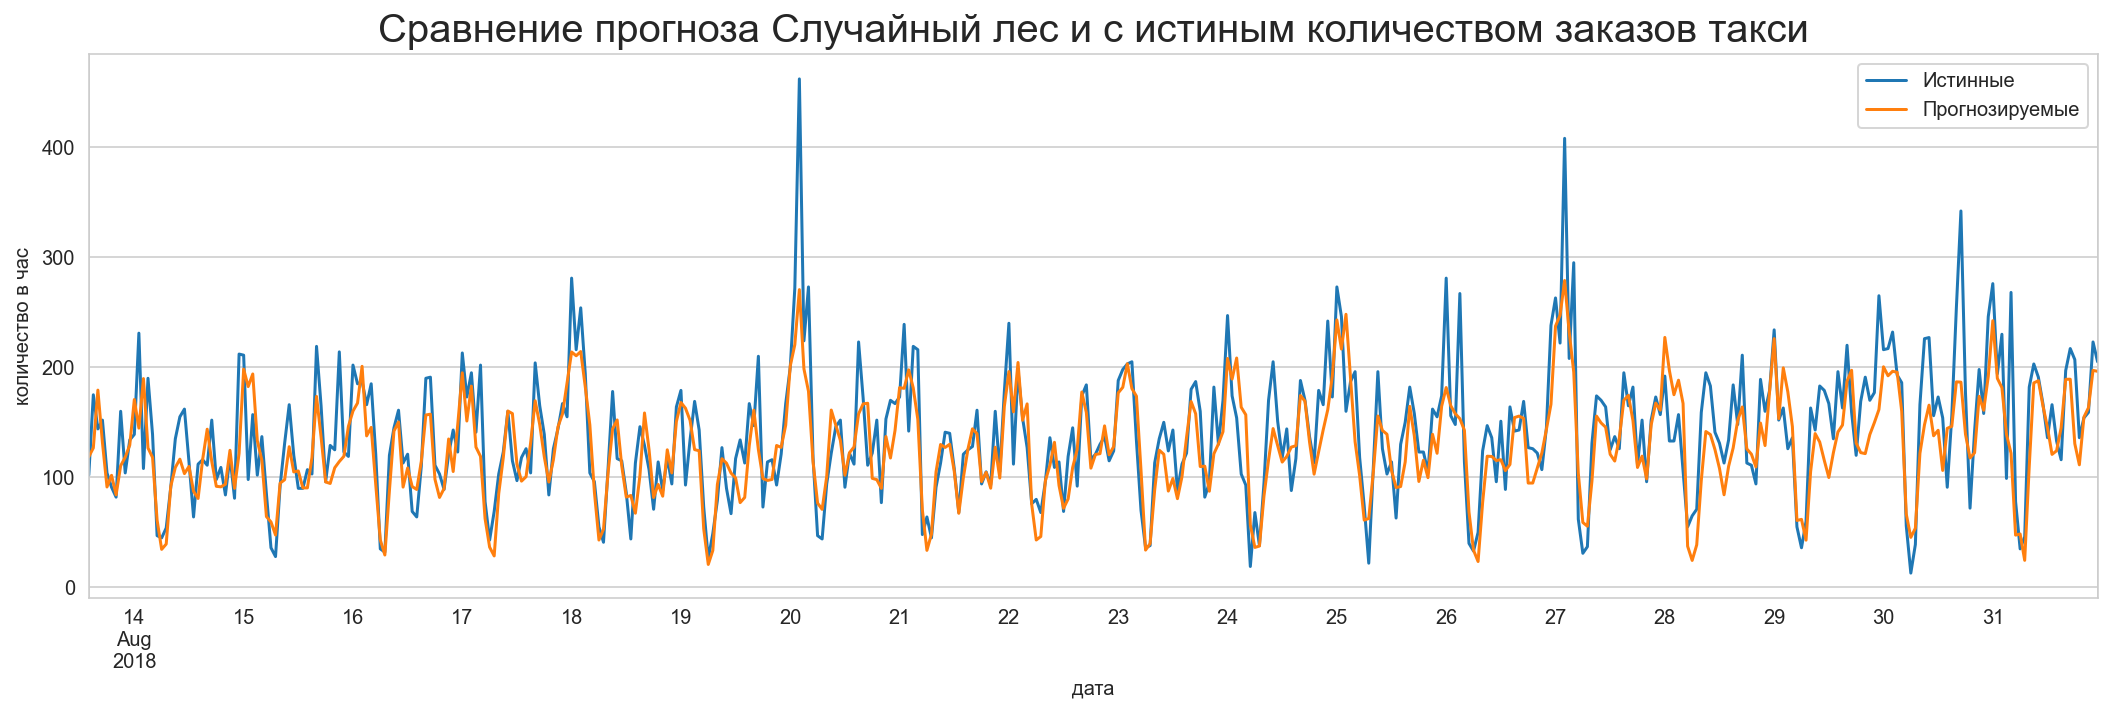

In [45]:
# Отображение предсказания и истинных значений
ax = pd.DataFrame(data = {'Истинные':target_test, 'Прогнозируемые':pred_test_lr}).plot(figsize=(18, 5))
ax.set_title('Сравнение прогноза Случайный лес и с истиным количеством заказов такси', fontsize=20)
ax.set(ylabel='количество в час', xlabel='дата');


In [46]:
# CatBoost
pred_test_cat = best_cat.predict(features_test)
cat_rmse = rmse(target_test, pred_test_cat)
print(f'RMSE модели CatBoost на тестовой выборке: {cat_rmse:.2f}')


RMSE модели CatBoost на тестовой выборке: 37.20


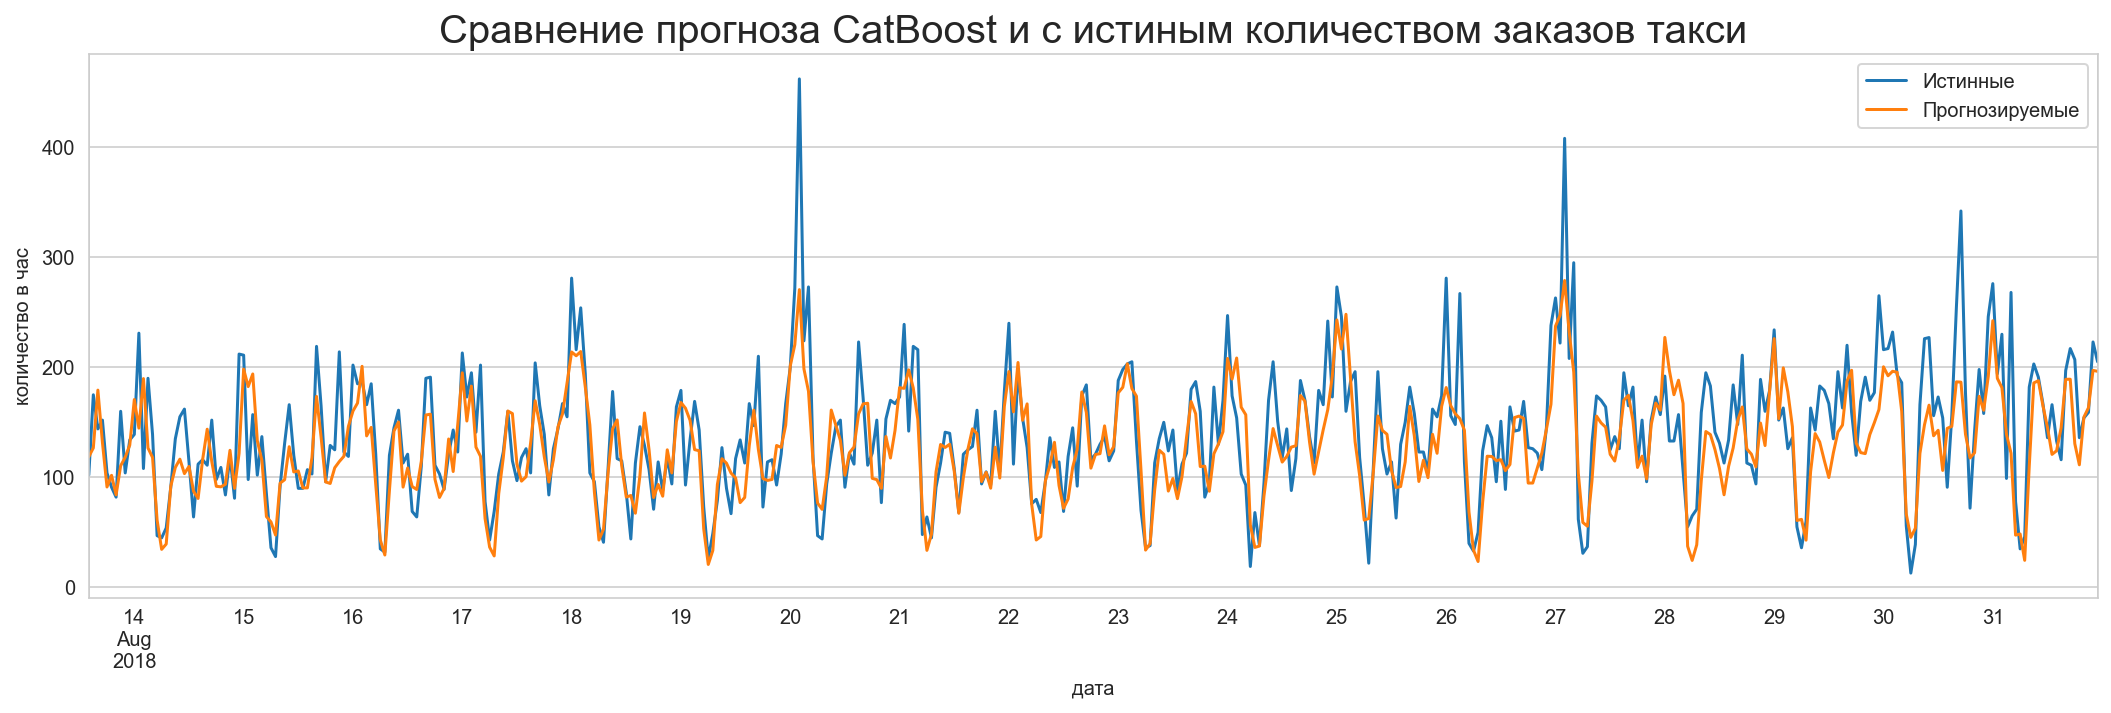

In [47]:
# Отображение предсказания и истинных значений
ax = pd.DataFrame(data = {'Истинные':target_test, 'Прогнозируемые':pred_test_lr}).plot(figsize=(18, 5))
ax.set_title('Сравнение прогноза CatBoost и с истиным количеством заказов такси', fontsize=20)
ax.set(ylabel='количество в час', xlabel='дата');


### **Вывод**

Все модели преодолели заданное пороговое значение равное 48.

Лучший результат на тестовой выборке у модели Линейная регрессия. На втором месте модель CatBoost с несзначительным отставанием. Но так как Линейная регрессия самая быстрая модель, то она предпочтительней.

Случайный лес на тестовой выборке самый худший - RMSE = 38.

### Проверка модели на адекватность
Произведём сравнение качества работы модели на тестовой выборке с качеством прогнозирования константной модели и модели прогнозирующей предъидущим значением.

In [48]:
# Рассчитаем RMSE для константной модели
print('RMSE =', rmse(target_test, (np.ones(target_test.shape[0]) * target_test.median())))

RMSE = 58.7266464607412


In [49]:
# Рассчитаем RMSE для модели прогнозирующей по предъидущему шагу
pred_previous = target_test.shift(fill_value=target_train.iloc[-1])
print('RMSE =', rmse(target_test, pred_previous))

RMSE = 58.856486242815066


**Вывод**

Константная модель и модель прегнозирующая по предыдущему шагу показывают худшее качество не только по сравнению с созданными моделями, но и хуже порогового значения.

### Важность признаков

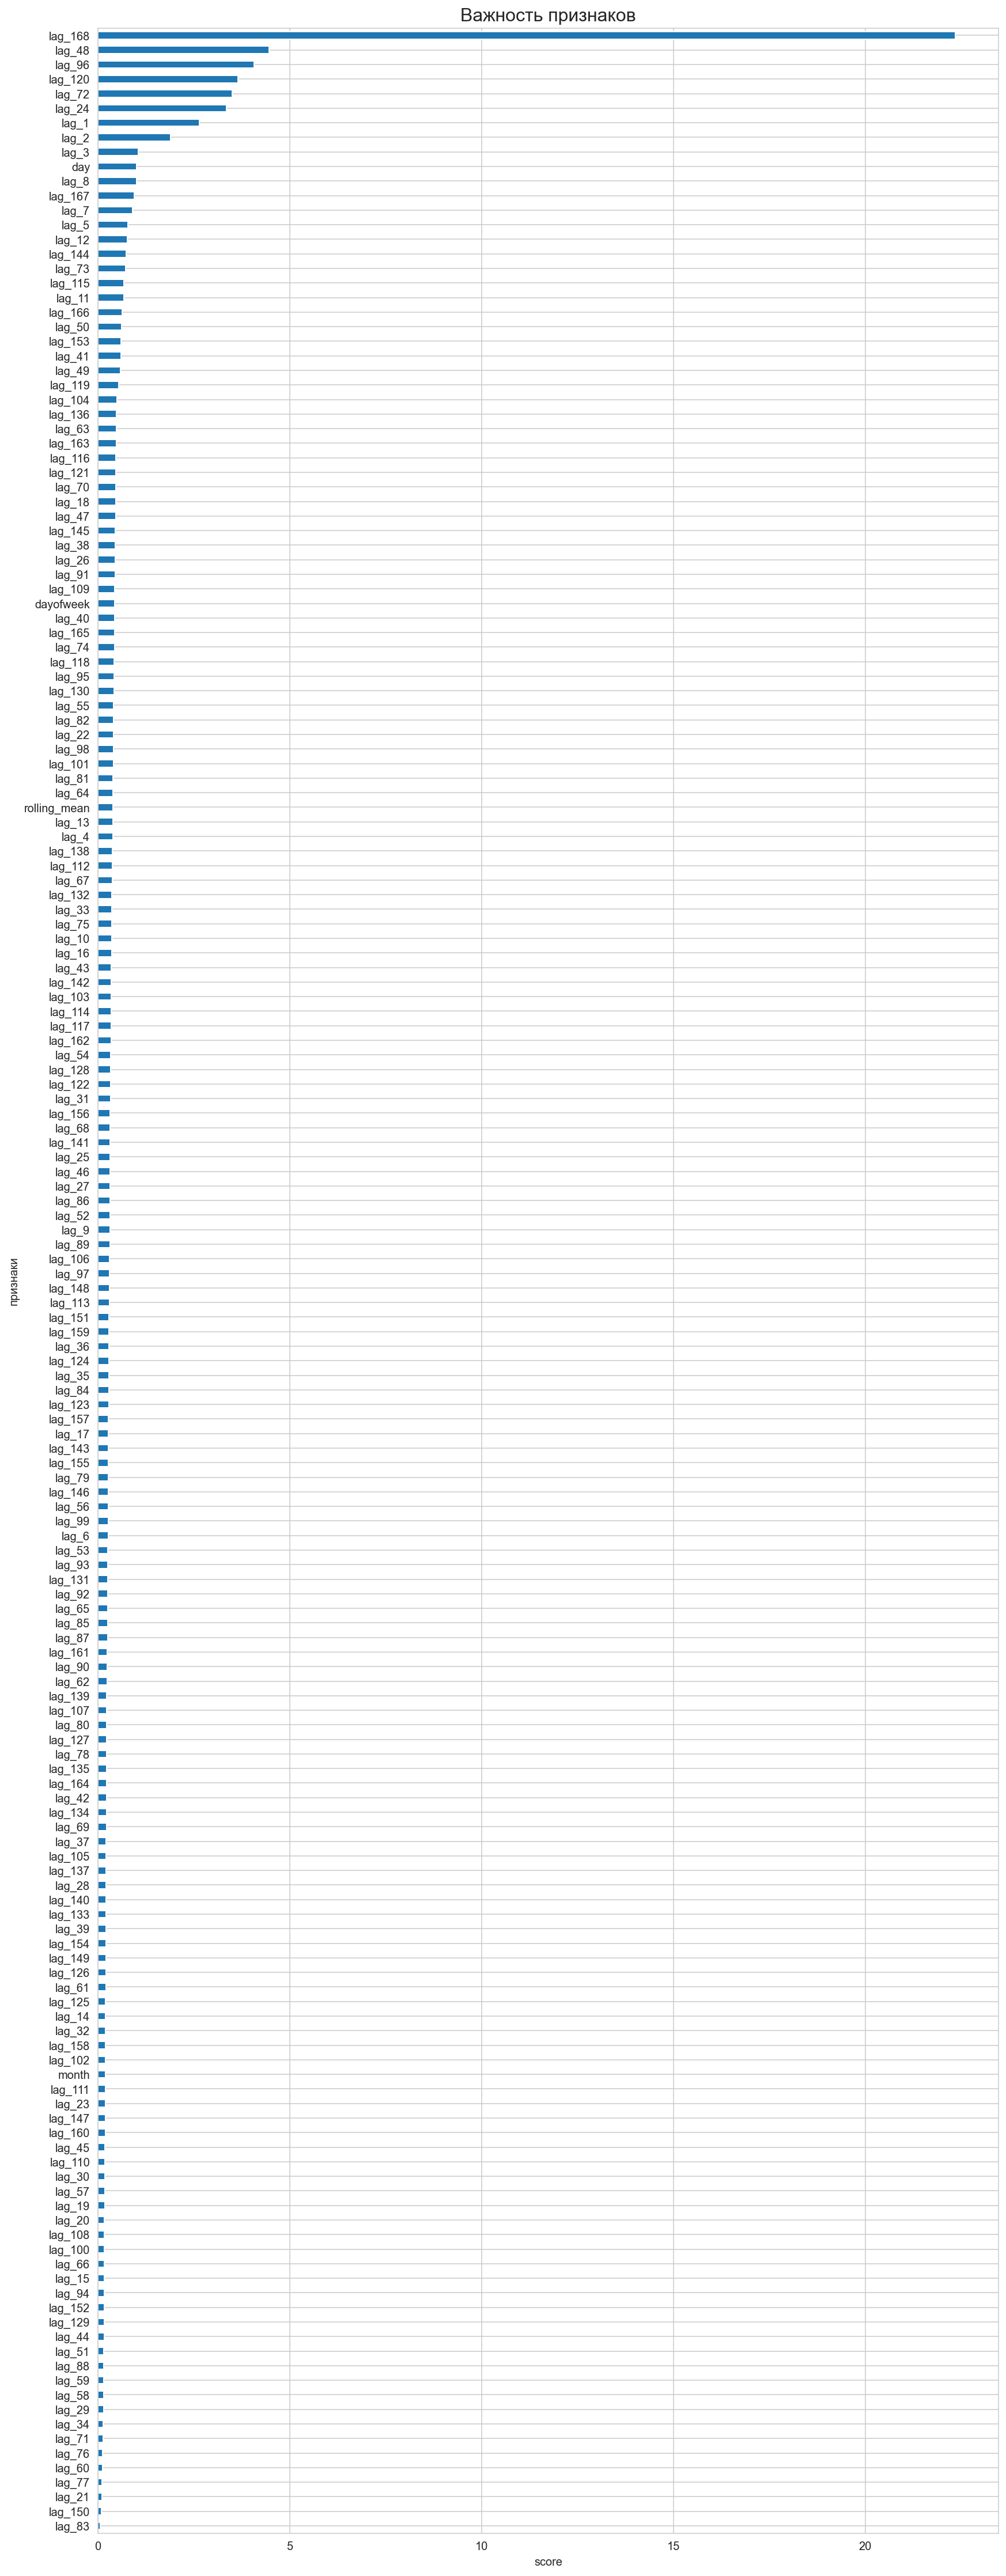

In [50]:
model = CatBoostRegressor(silent=True, random_state=RSTATE)
# Обучение модели
model.fit(features_train, target_train)
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': model.feature_importances_}, 
                            index=features_train.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(14,40), legend=False);
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

### **Вывод**

Самым важным признаком с оценкой 22 является сдвиг на 168 часа. Это соответствует недельной сезонности, которую наблюдали при анализе данных. 

Следующая группу из 6 признаков с оценкой важности между 2.5 и 5 составляют сдвиги на 120, 48, 24, 72, 96 и 1 час. 

Еще 4 признака с оценкой больше еденицы. А важность остальных 160 признаков меньше еденицы.

## Общий вывод

На этапе подготовки данных произвели первичный анализ данных и ресемплирование данных в соответствии с поставленной задачей.

Далее проанализировали данные с помощью разделения данных на составляющие: тренд, сезонность и остаток. Наблюдается восходящий тренд количества заказов такси на протяжении всего периода наблюдения. Активность клиентов такси имеет характер недельной и дневной сезонности. Пики использования такси для поездок в аэропорт - понедельник и пятница. Меньше всего заказов в четверг. Дневная сезонность выражена наименьшим числом заказов в ночные часы, и плавным ростом активности поездок с утра и до вечера.

Для обучения моделей были созданы признаки путём сдвига данных, добавления скользящего среднего и создания признаков содержащих день, день недели и месяц. Затем было произведено обучение с подбором гиперпараметров нескольких моделей: LinearRegression, RandomForestRegressor, CatBoostRegressor.

По результатам тестирования все полученные модели прошли проверку на адекватность и преодолели заданные порог оценки RMSE=48. Окончательный выбор модели предлагается сделать в пользу модели  LinearRegression с лучшей оценкой RMSE = 36.54 на тестовой выборке. К тому же эта модель самая быстрая в обучении. 

Таким образом, задача по созданию модели прогнозирующей количество заказов такси на следующий час выполненна. Одним из путей повышение качества модели может быть добавление в качестве признаков расписания авиарейсов.